In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from itertools import chain
from collections import Counter
from wordcloud import WordCloud

from src.data.some_dataloader import *

In this notebook we will: 
- find how often each article is used in the Wikispeedia game (i.e. how many times each article was clicked on)
- find articles that are most/least used 
- link each article to its category 
- find most used categories

# Import data 

In [3]:
articles = load_articles_dataframe()
categories = load_categories_dataframe()
finished_paths = load_path_finished_dataframe()
unfinished_paths = load_path_unfinished_distance_dataframe()
links = load_links_dataframe()

In [4]:
articles

,articles
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in
1,%C3%85land
2,%C3%89douard_Manet
3,%C3%89ire
4,%C3%93engus_I_of_the_Picts
...,...
4599,Zionism
4600,Zirconium
4601,Zoroaster
4602,Zuid-Gelders


In [5]:
categories

,articles,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
2,%C3%85land,subject.Countries
3,%C3%85land,subject.Geography.European_Geography.European_...
4,%C3%89douard_Manet,subject.People.Artists
...,...,...
5199,Zirconium,subject.Science.Chemistry.Chemical_elements
5200,Zoroaster,subject.People.Religious_figures_and_leaders
5201,Zuid-Gelders,subject.Geography.European_Geography
5202,Zuid-Gelders,subject.Language_and_literature.Languages


In [6]:
finished_paths

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0
...,...,...,...,...,...
51313,15a13a1d66ef5456,1349231015,66,Yagan;Ancient_Egypt;Civilization,NaN
51314,2ef7ac844cefda58,1300254138,165,Yagan;Folklore;Brothers_Grimm;<;19th_century;C...,3.0
51315,12863abb7887f890,1385095372,228,Yagan;Australia;England;France;United_States;T...,NaN
51316,19f8284371753362,1298792567,56,Yarralumla%2C_Australian_Capital_Territory;Aus...,1.0


In [7]:
unfinished_paths

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout
...,...,...,...,...,...,...
24870,109ed71f571d86e9,1389787605,180,Franz_Kafka;Tuberculosis;World_Health_Organiza...,Cholera,restart
24871,232f992e57d43e8d,1389787697,6,Modern_history,Hollandic,restart
24872,2e09a7224600a7cd,1389798400,1900,Computer_programming;Linguistics;Culture;Popul...,The_Beatles,timeout
24873,60af9e2138051b96,1389799481,1903,Jamaica;United_Kingdom;World_War_II;Battle_of_...,Alan_Turing,timeout


In [8]:
links

,linkSource,linkTarget
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland
...,...,...
119877,Zulu,South_Africa
119878,Zulu,Swaziland
119879,Zulu,United_Kingdom
119880,Zulu,Zambia


# Usage of articles

In [9]:
paths = pd.concat([finished_paths["path"], unfinished_paths["path"]])

paths_merged = paths.apply(lambda row: row.split(';'))

clicks_list = paths_merged.values.flatten().tolist()
clicks_list = list(chain.from_iterable(clicks_list))

print(f'there are {len(clicks_list)} clicks in the whole whikispeedia dataset (both finished and unfinished paths)')

there are 476073 clicks in the whole whikispeedia dataset (both finished and unfinished paths)


In [10]:
article_list = list(articles['articles'])

# count number of occurences of each article
counts = Counter(clicks_list)
occurences = {item: counts[item] for item in article_list}

df_articles_count = pd.DataFrame(list(occurences.items()), columns = ['articles', 'click_count']).set_index('articles') # df containing the click counts for each article
df_articles_count.index.name = None
df_articles_count

,click_count
%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,0
%C3%85land,4
%C3%89douard_Manet,7
%C3%89ire,13
%C3%93engus_I_of_the_Picts,0
...,...
Zionism,27
Zirconium,34
Zoroaster,20
Zuid-Gelders,10


Now we load the *country_occurrences.csv* and merge this dataframe with df_articles_count to obtain a new DataFrame containing: 
- Top_1_name = name of the country that occurs the most in the article
- Top_2_name = name of the country that occurs the second most in the article
- Top_1_count = number of times that the Top1 country occurs
- Top_2_count = number of times that the Top2 country occurs
- click_count = number of times the article occurs in the clicking paths of the Wikispeedia game

In [11]:
df_country_occurences = pd.read_csv("data/country_occurences.csv", names = ["Top_1_name", "Top_2_name", "Top_1_count", "Top_2_count"], skiprows=1)

df_articles_country_clicks = pd.concat([df_country_occurences, df_articles_count], axis=1)
df_articles_country_clicks

,Top_1_name,Top_2_name,Top_1_count,Top_2_count,click_count
%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland,Isle of Man,8.0,4.0,0
%C3%85land,Finland,Åland Islands,36.0,16.0,4
%C3%89douard_Manet,Italy,France,2.0,2.0,7
%C3%89ire,Ireland,Canada,43.0,4.0,13
%C3%93engus_I_of_the_Picts,Ireland,NaN,9.0,NaN,0
...,...,...,...,...,...
Zirconium,India,NaN,2.0,NaN,34
Zoroaster,Iran,Tajikistan,15.0,3.0,20
Zuid-Gelders,Netherlands,Germany,2.0,2.0,10
Zulu,South Africa,Zimbabwe,15.0,3.0,55


In [12]:
df_articles_country_clicks.to_csv('data/country_clicks.csv')

### Visualization of article occurrences

In [13]:
df_articles_count_sorted = df_articles_count.sort_values(by='click_count', ascending=False)

**Most used articles**

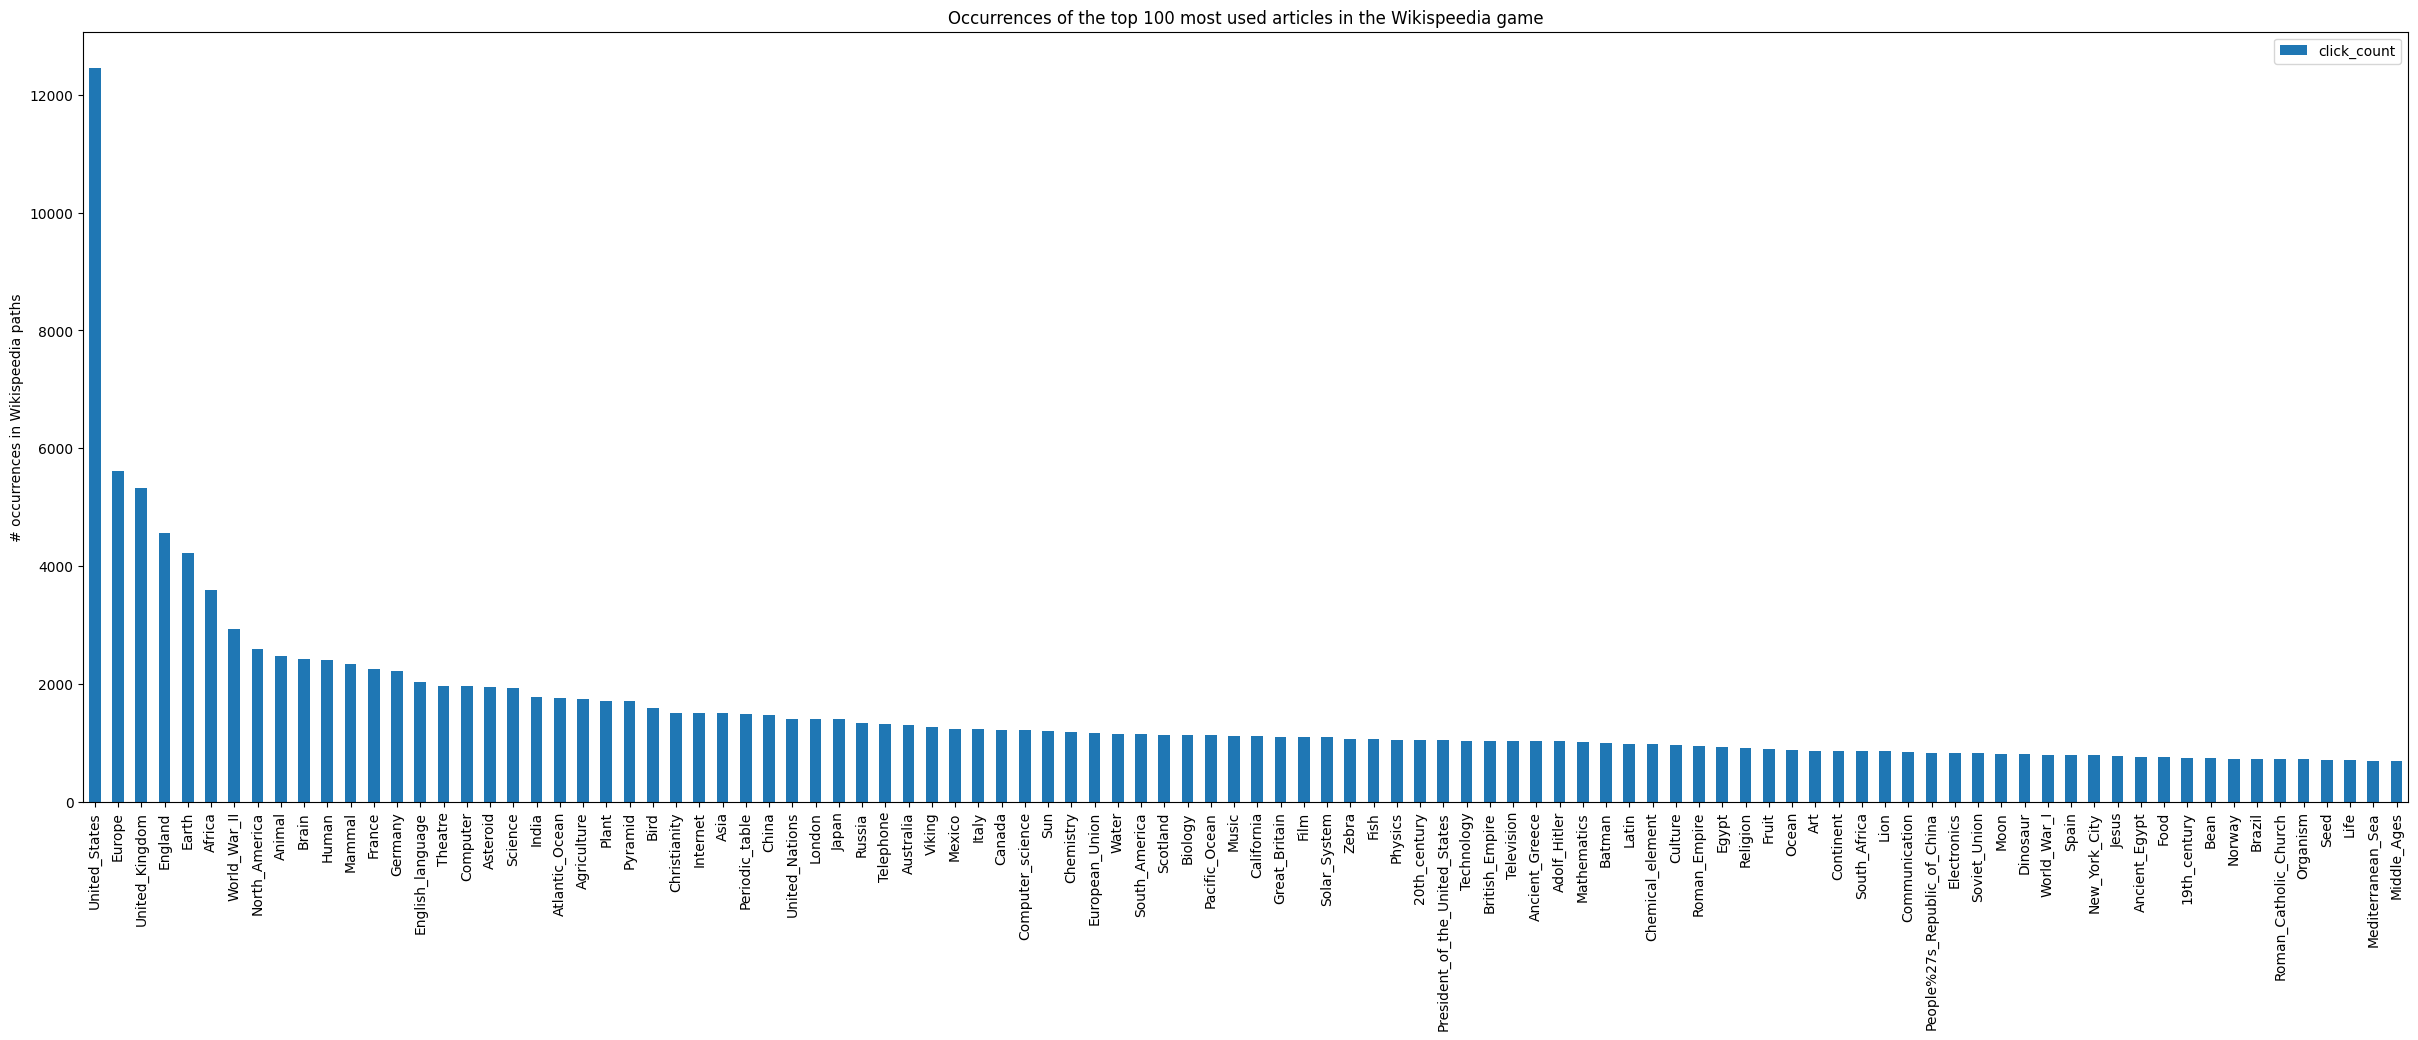

In [14]:
# plot the most used articles 
df_articles_count_sorted.head(100).plot(kind='bar', stacked=True, figsize=(30, 10))

plt.xticks(ticks=range(len(df_articles_count_sorted.head(100))), labels=df_articles_count_sorted.index.tolist()[0:100], fontsize=10)
plt.ylabel('# occurrences in Wikispeedia paths')
plt.title("Occurrences of the top 100 most used articles in the Wikispeedia game")
plt.show()

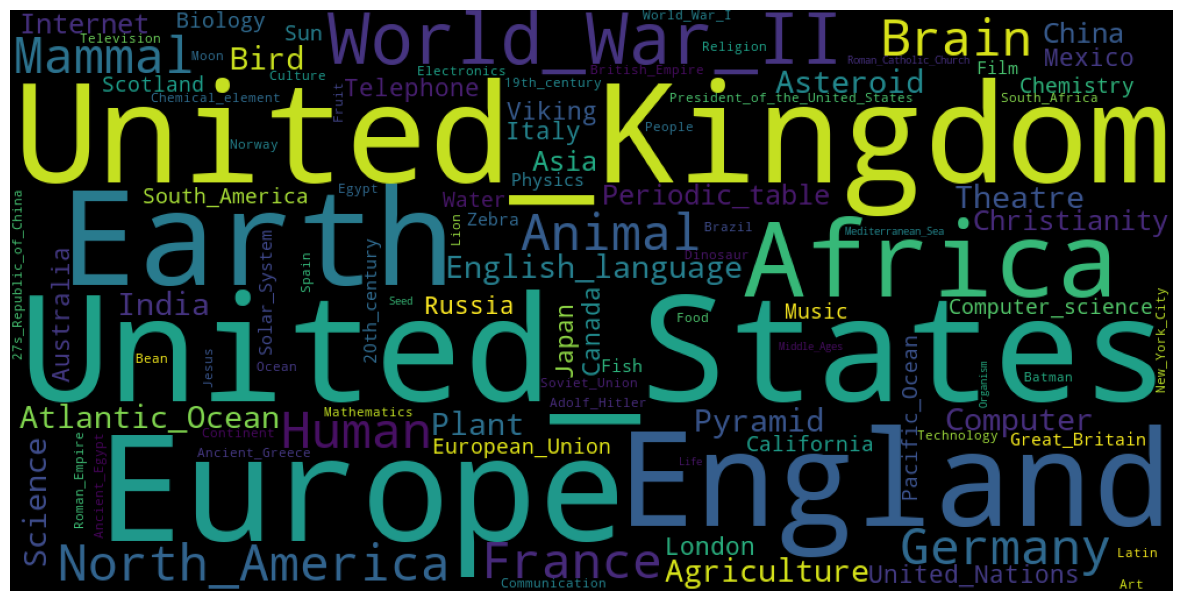

In [15]:
# alternative fun visualization of most used articles 
unique_string=(" ").join(list(df_articles_count_sorted.index.tolist()[0:100]))
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
#plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()
plt.close()

**Least used articles**

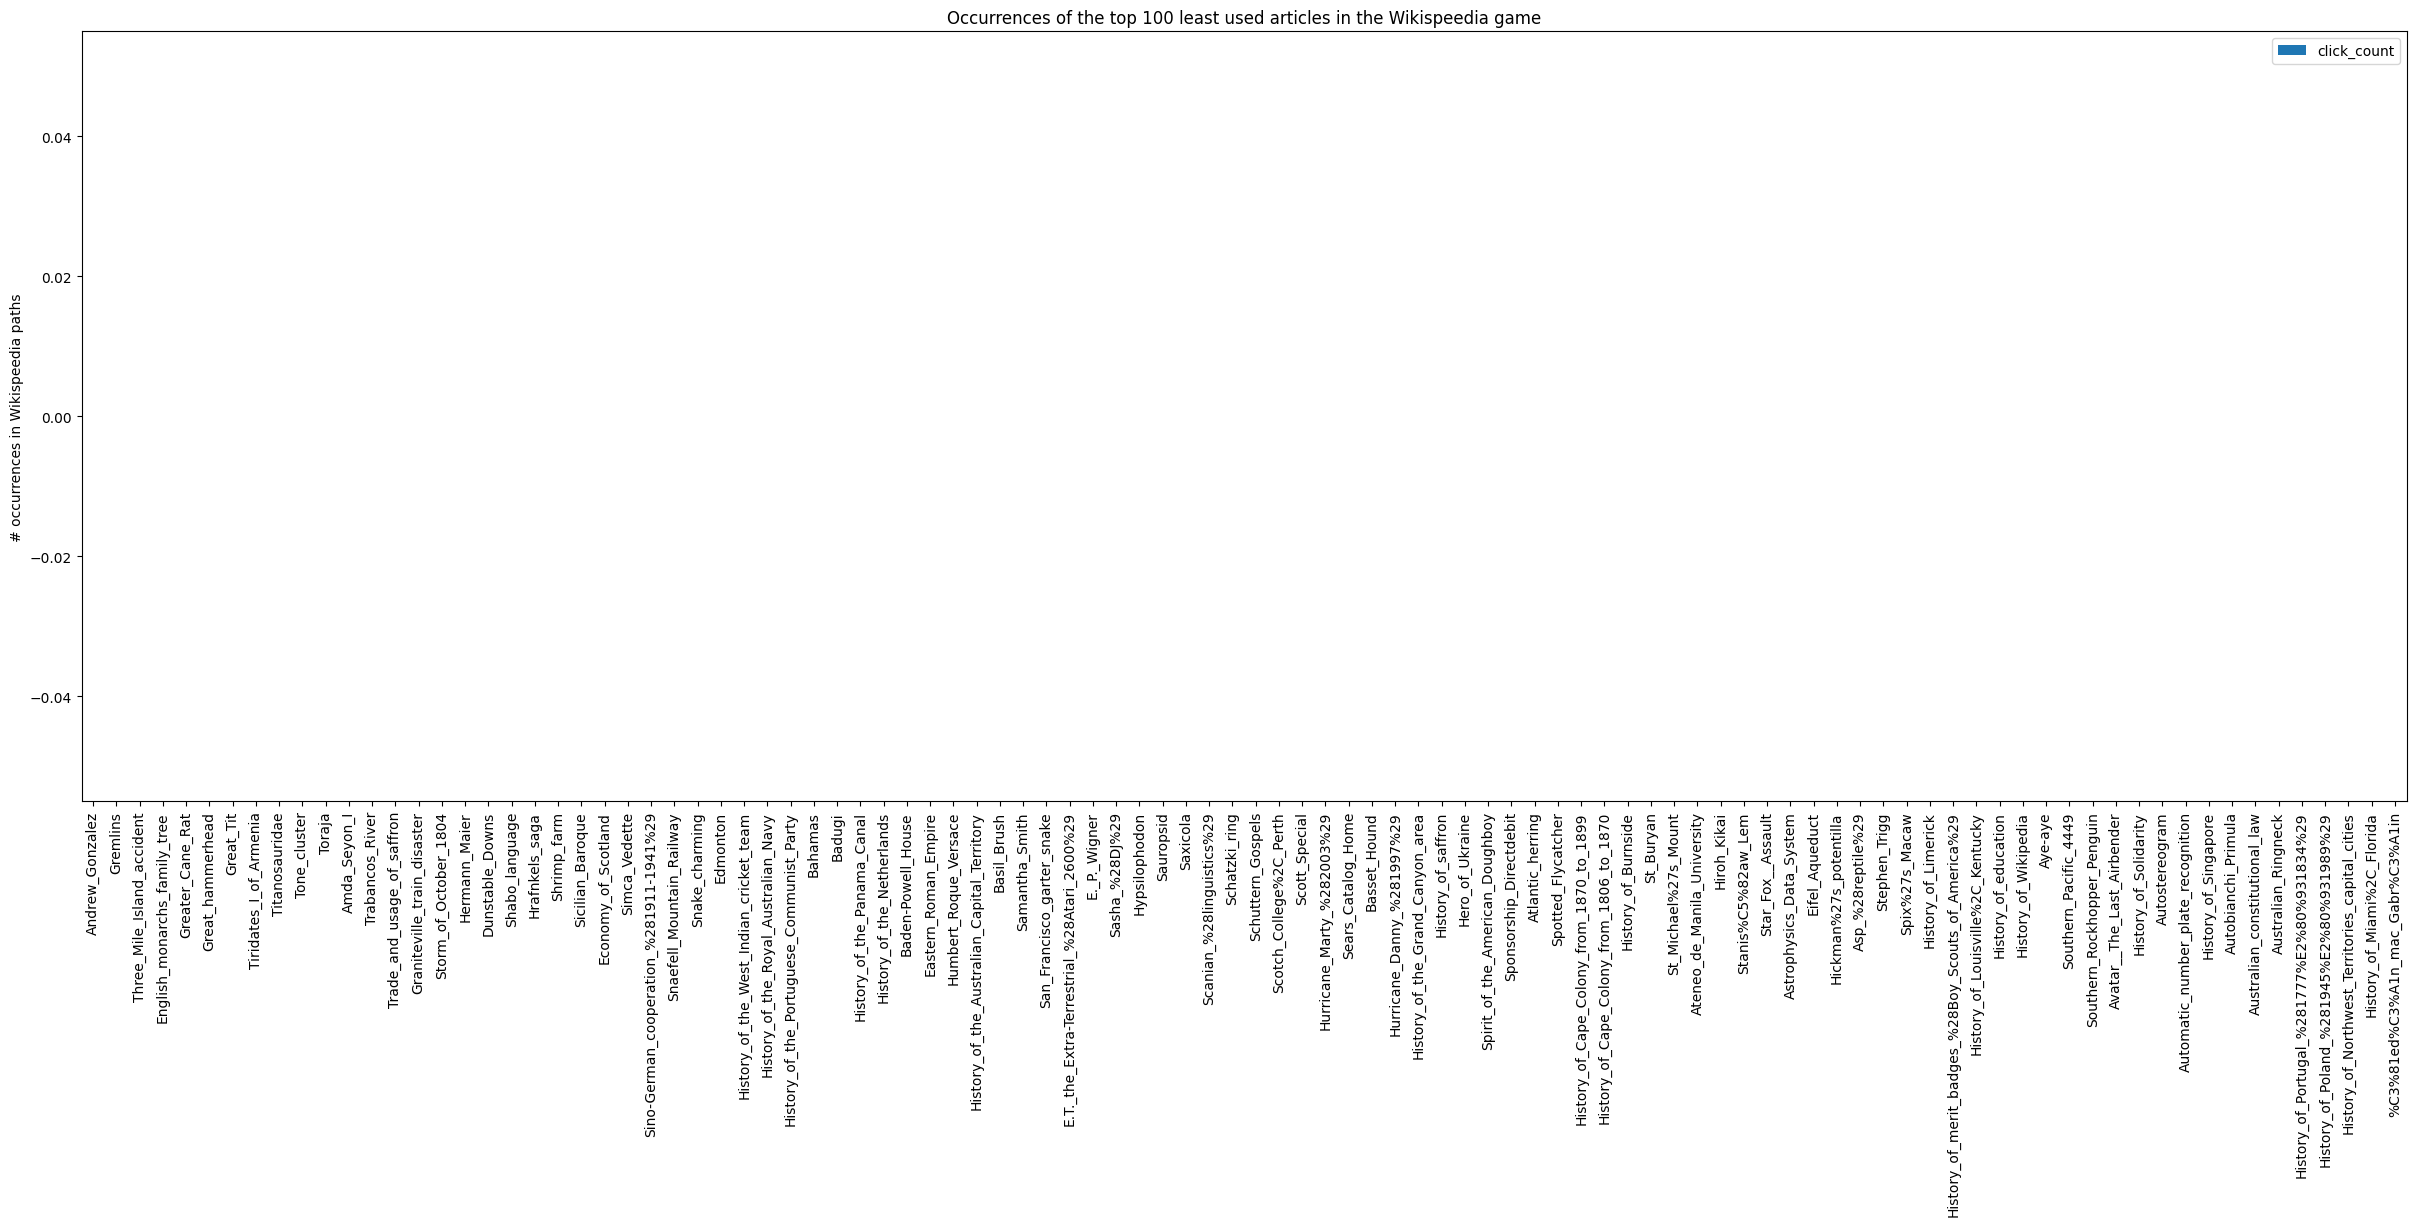

In [16]:
# plot the least used articles 
df_articles_count_sorted.tail(100).plot(kind='bar', stacked=True, figsize=(30, 10))

plt.xticks(ticks=range(len(df_articles_count_sorted.tail(100))), labels=df_articles_count_sorted.index.tolist()[-100:], fontsize=10)
plt.ylabel('# occurrences in Wikispeedia paths')
plt.title("Occurrences of the top 100 least used articles in the Wikispeedia game")
plt.show()

# so many articles are never used (never clicked :( sniiif)

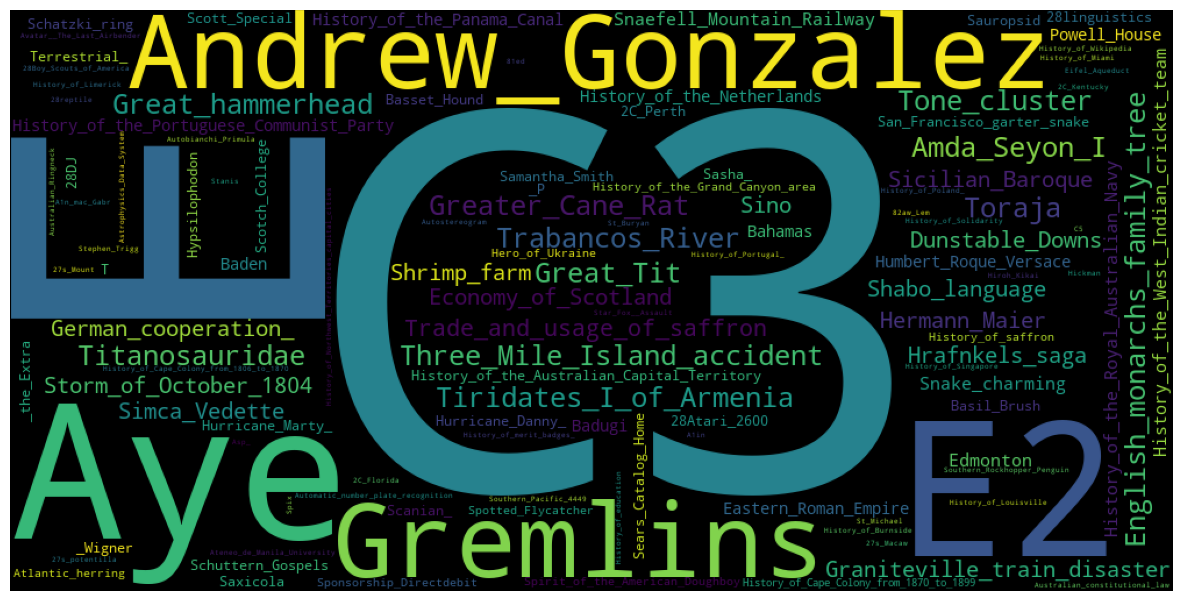

In [17]:
# alternative fun visualization of least used articles 
unique_string=(" ").join(list(df_articles_count_sorted.index.tolist()[-100:]))
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
#plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()
plt.close()

**Articles that are nerver used and/or that are associated to no country**

In [18]:
# find articles that are never clicked on
never_used_articles = df_articles_count[df_articles_count['click_count'] == 0]
print(f'there are {len(never_used_articles)} articles that are never clicked on in the game')

no_country_articles = df_articles_country_clicks[df_articles_country_clicks['Top_1_name'].isna() == True]
print(f'there are {len(no_country_articles)} articles that are associated to no country')

nerver_used_no_country = np.intersect1d(never_used_articles.index.tolist(), no_country_articles.index.tolist()).tolist()
print(f'there are {len(nerver_used_no_country)} articles that are associated to no country AND that are never clicked --> least interesting articles')

there are 422 articles that are never clicked on in the game
there are 1247 articles that are associated to no country
there are 146 articles that are associated to no country AND that are never clicked --> least interesting articles


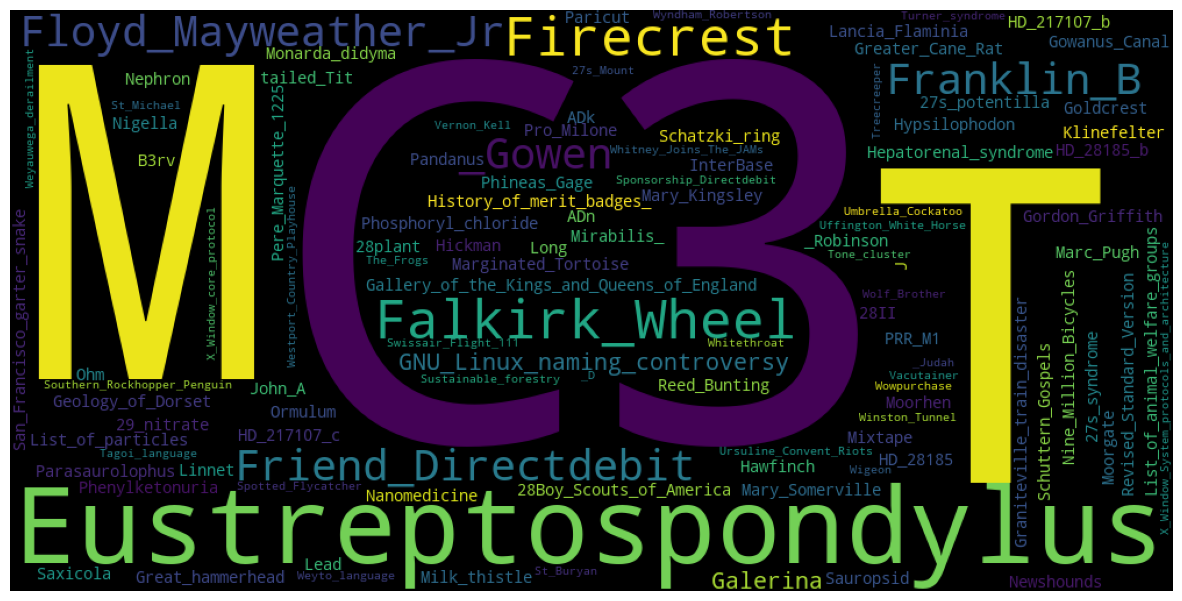

In [19]:
# alternative fun visualization of least interesting articles 
unique_string=(" ").join(list(nerver_used_no_country[-100:]))
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
#plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()
plt.close()

**Number of clicks per country**

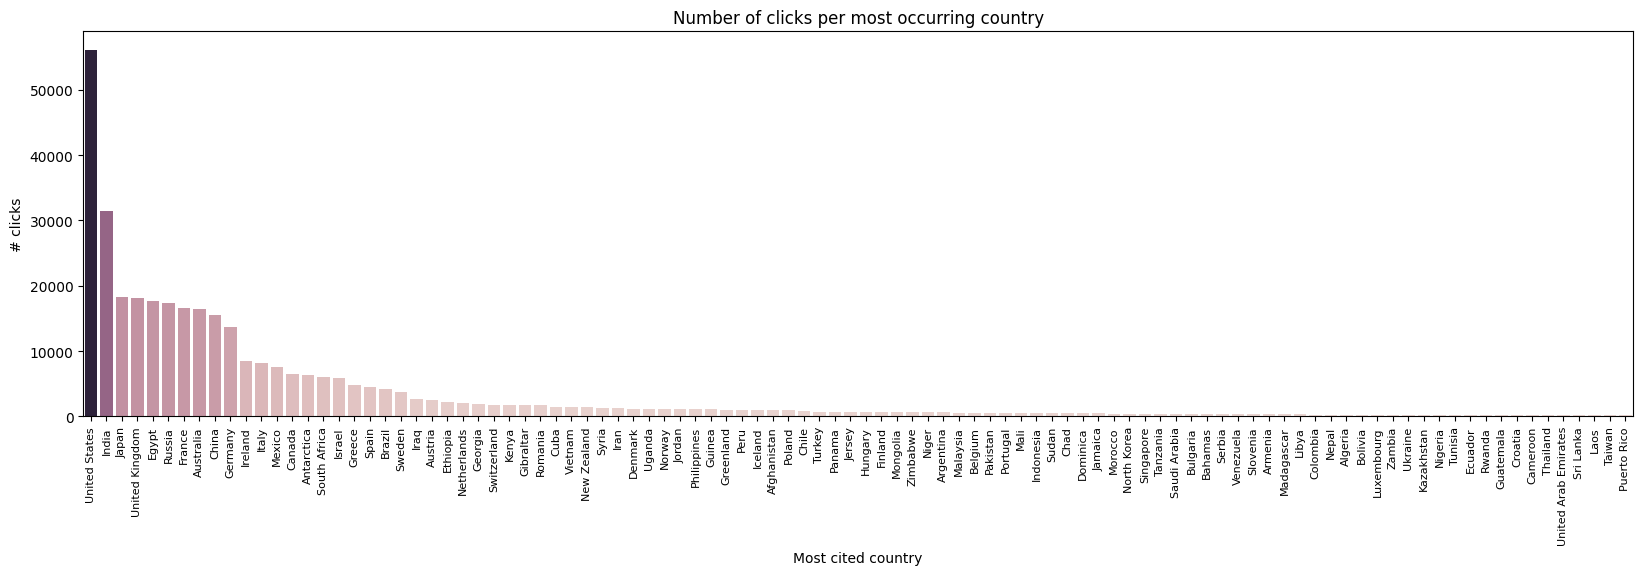

In [20]:
country_clicks = df_articles_country_clicks.groupby('Top_1_name')['click_count'].sum().reset_index()
sorted_country_clicks = country_clicks.sort_values(by='click_count', ascending=False)

plt.figure(figsize=(20,5))
sns.barplot(x="Top_1_name", y="click_count", hue='click_count', data=sorted_country_clicks.head(100), legend=False)

plt.xticks(ticks=range(len(sorted_country_clicks.head(100))), labels=sorted_country_clicks['Top_1_name'].head(100), fontsize=8, rotation=90)
plt.ylabel('# clicks')
plt.xlabel("Most cited country")
plt.title("Number of clicks per most occurring country")
plt.show()

# Number of links in and out of articles 

### Links out

In [70]:
num_links_out = links.groupby('linkSource').agg('count').reset_index()
num_links_out = num_links_out.set_index('linkSource')
num_links_out.index.name = None
num_links_out = num_links_out.rename(columns={"linkTarget": "num_links_out"})
num_links_out

,num_links_out
%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,11
%C3%85land,19
%C3%89douard_Manet,20
%C3%89ire,8
%C3%93engus_I_of_the_Picts,10
...,...
Zionism,74
Zirconium,42
Zoroaster,28
Zuid-Gelders,5


In [ ]:
num_links_out["name_links_out"] = None

index_links_out = links.groupby('linkSource').groups # a dictionary whose keys are the computed unique groups and corresponding values are the axis labels belonging to each group. 
list_links_out = list(index_links_out.items())

for article in range(len(list_links_out)):
    num_links_out["name_links_out"].iloc[article] = links.iloc[list_links_out[article][1]]['linkTarget'].tolist()

num_links_out = num_links_out[:-1]

In [112]:
num_links_out

,num_links_out,name_links_out
%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,11.0,"[Bede, Columba, D%C3%A1l_Riata, Great_Britain,..."
%C3%85land,19.0,"[20th_century, Baltic_Sea, Crimean_War, Curren..."
%C3%89douard_Manet,20.0,"[Absinthe, Beer, Claude_Monet, Diego_Vel%C3%A1..."
%C3%89ire,8.0,"[Canada, English_language, George_VI_of_the_Un..."
%C3%93engus_I_of_the_Picts,10.0,"[D%C3%A1l_Riata, Durham, England, Great_Britai..."
...,...,...
Zion_National_Park,44.0,"[Agriculture, Animal, Arable_land, Bat, Bible,..."
Zionism,74.0,"[18th_century, 19th_century, Adolf_Hitler, Alb..."
Zirconium,42.0,"[Aluminium, Arabic_language, Australia, Bicycl..."
Zoroaster,28.0,"[18th_century, 9th_century, Afghanistan, Age_o..."


Let's also find which are the articles (names) that lead into the article of interest!

### Links in

In [114]:
num_links_in = links.groupby('linkTarget').agg('count').reset_index()
num_links_in = num_links_in.set_index('linkTarget')
num_links_in.index.name = None
num_links_in = num_links_in.rename(columns={"linkSource": "num_links_in"})
num_links_in

,num_links_in
10th_century,65
11th_century,57
12th_century,85
13th_century,84
14th_century,71
...,...
Zionism,25
Zirconium,15
Zoroaster,9
Zuid-Gelders,5


In [ ]:
num_links_in["name_links_in"] = None

index_links_in = links.groupby('linkTarget').groups # a dictionary whose keys are the computed unique groups and corresponding values are the axis labels belonging to each group. 
list_links_in = list(index_links_in.items())

for article in range(len(list_links_in)):
    num_links_in["name_links_in"].iloc[article] = links.iloc[list_links_in[article][1]]['linkSource'].tolist()

In [116]:
num_links_in

,num_links_in,name_links_in
10th_century,65,"[11th_century, 12th_century, 15th_century, 16t..."
11th_century,57,"[10th_century, 12th_century, 15th_century, 16t..."
12th_century,85,"[11th_century, 13th_century, 15th_century, 16t..."
13th_century,84,"[11th_century, 12th_century, 14th_century, 15t..."
14th_century,71,"[11th_century, 12th_century, 13th_century, 15t..."
...,...,...
Zionism,25,"[19th_century, Abraham_Goldfaden, Albert_Einst..."
Zirconium,15,"[Calcium, Cerium, Diamond_simulant, Gas_metal_..."
Zoroaster,9,"[Friedrich_Nietzsche, Greco-Buddhism, Iran, Ir..."
Zuid-Gelders,5,"[Brabantian, Dutch_language, East_Flemish, Hol..."


### Save the new columns in a csv

This new .csv will contain 9 columns:
- **Top_1_name** = name of the country that occurs the most in the article
- **Top_2_name** = name of the country that occurs the second most in the article
- **Top_1_count** = number of times that the Top1 country occurs
- **Top_2_count** = number of times that the Top2 country occurs
- **click_count** = number of times the article occurs in the clicking paths of the Wikispeedia game
- **num_links_in** = number of articles that lead to article of interest 
- **name_links_in** = name of the artciles that lead to article of interest
- **num_links_out** = number of links in the article of interest, leading out of the article
- **name_links_out** = name of the articles that are references by the article of interest 

Each row is an article. 

In [117]:
df_articles_country_clicks_linksIn_linksOut = pd.concat([df_articles_country_clicks, num_links_in, num_links_out], axis=1)
df_articles_country_clicks_linksIn_linksOut.to_csv('data/country_clicks_links.csv')

In [119]:
df_articles_country_clicks_linksIn_linksOut

,Top_1_name,Top_2_name,Top_1_count,Top_2_count,click_count,num_links_in,name_links_in,num_links_out,name_links_out
%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland,Isle of Man,8.0,4.0,0,NaN,NaN,11.0,"[Bede, Columba, D%C3%A1l_Riata, Great_Britain,..."
%C3%85land,Finland,Åland Islands,36.0,16.0,4,NaN,NaN,19.0,"[20th_century, Baltic_Sea, Crimean_War, Curren..."
%C3%89douard_Manet,Italy,France,2.0,2.0,7,NaN,NaN,20.0,"[Absinthe, Beer, Claude_Monet, Diego_Vel%C3%A1..."
%C3%89ire,Ireland,Canada,43.0,4.0,13,NaN,NaN,8.0,"[Canada, English_language, George_VI_of_the_Un..."
%C3%93engus_I_of_the_Picts,Ireland,NaN,9.0,NaN,0,NaN,NaN,10.0,"[D%C3%A1l_Riata, Durham, England, Great_Britai..."
...,...,...,...,...,...,...,...,...,...
Zirconium,India,NaN,2.0,NaN,34,15.0,"[Calcium, Cerium, Diamond_simulant, Gas_metal_...",42.0,"[Aluminium, Arabic_language, Australia, Bicycl..."
Zoroaster,Iran,Tajikistan,15.0,3.0,20,9.0,"[Friedrich_Nietzsche, Greco-Buddhism, Iran, Ir...",28.0,"[18th_century, 9th_century, Afghanistan, Age_o..."
Zuid-Gelders,Netherlands,Germany,2.0,2.0,10,5.0,"[Brabantian, Dutch_language, East_Flemish, Hol...",5.0,"[Brabantian, Dutch_language, East_Flemish, Hol..."
Zulu,South Africa,Zimbabwe,15.0,3.0,55,14.0,"[19th_century, Africa, History_of_South_Africa...",NaN,NaN
